_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

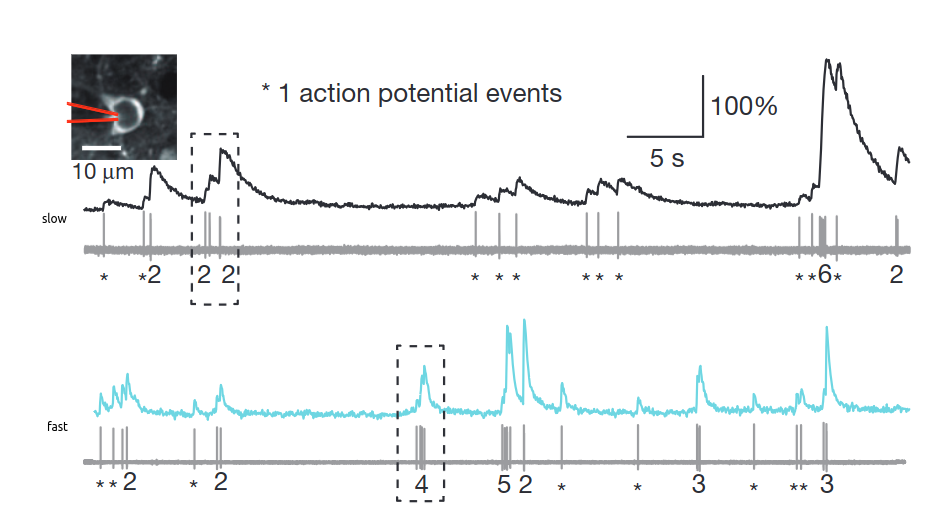

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-11 22:15:58CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.30.0

sklearn: 1.6.1

pandas    : 2.2.3
scipy     : 1.15.2
numpy     : 2.2.4
seaborn   : 0.13.2
matplotlib: 3.10.1

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
# ogb_spikes.head()
# ogb_calcium.head()
ogb_spikes

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
71981,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71982,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71983,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71984,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

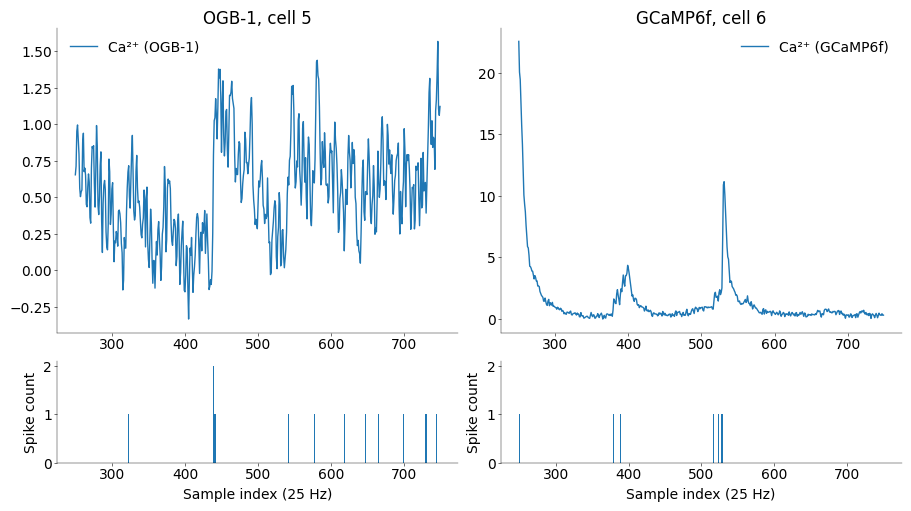

In [4]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

# downsample calcium: 100->25 Hz (q=4), zero_phase to avoid lag
ogb_cal_ds = signal.decimate(
    ogb_calcium.values, q=4, axis=0, ftype="iir", zero_phase=True
)
gcamp_cal_ds = signal.decimate(
    gcamp_calcium.values, q=4, axis=0, ftype="iir", zero_phase=True
)


# downsample spikes: 100->25Hz
def bin_spikes(arr, q=4):
    L = (arr.shape[0] // q) * q
    return arr[:L].reshape(-1, q, arr.shape[1]).sum(axis=1)


ogb_spk_ds = bin_spikes(ogb_spikes.values)
gcamp_spk_ds = bin_spikes(gcamp_spikes.values)

# pick cells 5 and 6
cell_ogb = ogb_cal_ds[:, 4]
spk_ogb = ogb_spk_ds[:, 4]
cell_gcam = gcamp_cal_ds[:, 5]
spk_gcam = gcamp_spk_ds[:, 5]

# e.g. zoom from 10 s to 30 s → samples 10*25=250 to 30*25=750
i0, i1 = 250, 750
n_ds = ogb_cal_ds.shape[0]
idx = np.arange(n_ds)

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), gridspec_kw={"height_ratios": [3, 1]}, layout="constrained"
)
# Top-left: OGB Ca + spikes
ax_ogb = axs[0, 0]
ax_ogb.plot(idx[i0:i1], cell_ogb[i0:i1], label="Ca²⁺ (OGB-1)")
ax_ogb.set_title("OGB-1, cell 5")
ax_ogb.legend()

# Bottom-left: spike histogram
ax_ogb_hist = axs[1, 0]
ax_ogb_hist.bar(idx[i0:i1], spk_ogb[i0:i1], width=1.0)
ax_ogb_hist.set_xlabel("Sample index (25 Hz)")
ax_ogb_hist.set_ylabel("Spike count")

# Top-right: GCaMP Ca
ax_gcam = axs[0, 1]
ax_gcam.plot(idx[i0:i1], cell_gcam[i0:i1], label="Ca²⁺ (GCaMP6f)")
ax_gcam.set_title("GCaMP6f, cell 6")
ax_gcam.legend()

# Bottom-right: GCaMP spike histogram
ax_gcam_hist = axs[1, 1]
ax_gcam_hist.bar(idx[i0:i1], spk_gcam[i0:i1], width=1.0)
ax_gcam_hist.set_xlabel("Sample index (25 Hz)")
ax_gcam_hist.set_ylabel("Spike count")

plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [5]:
def butterworth_filter(data, fs=25.0, cutoff=2.0, order=2):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = signal.butter(order, norm_cutoff, btype="low", analog=False)
    return signal.filtfilt(b, a, data)


def iterative_smoothing(trace, thr_noise=1.0, max_iter=5000):
    trace = np.copy(trace)
    for _ in range(max_iter):
        # Find peaks
        peaks, _ = signal.find_peaks(trace)
        if len(peaks) < 2:
            break

        # Find minimum amplitude difference between adjacent peaks
        diffs = [
            abs(trace[peaks[i]] - trace[peaks[i - 1]]) for i in range(1, len(peaks))
        ]
        if not diffs:
            break

        min_idx = np.argmin(diffs) + 1
        min_peak = peaks[min_idx]

        if diffs[min_idx - 1] >= thr_noise:
            break

        # Smooth region between neighboring peaks
        start = peaks[min_idx - 1]
        end = peaks[min_idx + 1] if min_idx + 1 < len(peaks) else len(trace) - 1

        segment = trace[start : end + 1]
        for _ in range(3):  # 3 passes of local averaging
            segment[1:-1] = (segment[:-2] + segment[1:-1] + segment[2:]) / 3.0

        trace[start : end + 1] = segment

    return trace

In [6]:
segment_ogb = cell_ogb[250:750]
segment_gcamp = cell_gcam[250:750]
# Apply filtering and smoothing
cell_ogb_filtered = butterworth_filter(segment_ogb, fs=25.0, cutoff=2.0)
cell_ogb_smoothed = iterative_smoothing(cell_ogb_filtered, thr_noise=0.2)

cell_gcam_filtered = butterworth_filter(segment_gcamp, fs=25.0, cutoff=2.0)
cell_gcam_smoothed = iterative_smoothing(cell_gcam_filtered, thr_noise=1.0)

In [7]:
cell_ogb[i0:i1].shape

(500,)

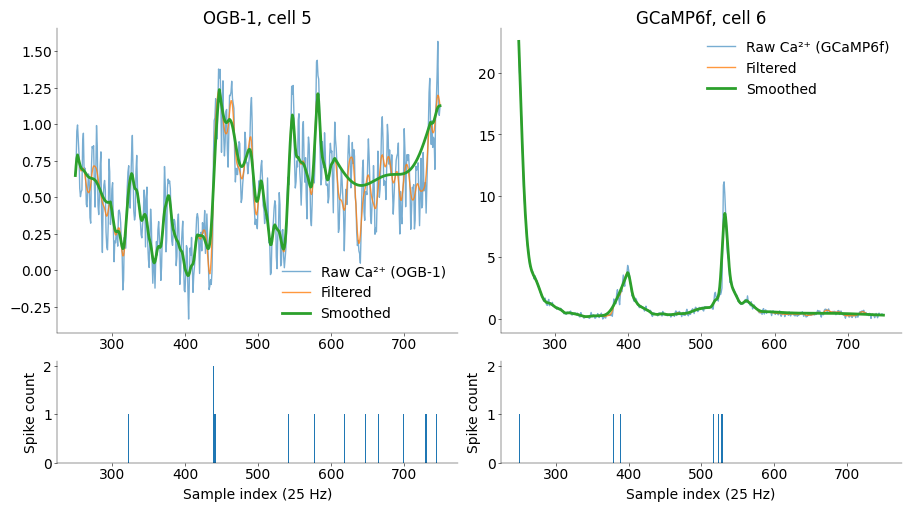

In [8]:
fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), gridspec_kw={"height_ratios": [3, 1]}, layout="constrained"
)

# Top-left: OGB Ca + spikes
ax_ogb = axs[0, 0]
ax_ogb.plot(idx[i0:i1], cell_ogb[i0:i1], label="Raw Ca²⁺ (OGB-1)", alpha=0.6)
ax_ogb.plot(idx[i0:i1], cell_ogb_filtered, label="Filtered", alpha=0.8)
ax_ogb.plot(idx[i0:i1], cell_ogb_smoothed, label="Smoothed", linewidth=2)
ax_ogb.set_title("OGB-1, cell 5")
ax_ogb.legend()

# Bottom-left: spike histogram
ax_ogb_hist = axs[1, 0]
ax_ogb_hist.bar(idx[i0:i1], spk_ogb[i0:i1], width=1.0)
ax_ogb_hist.set_xlabel("Sample index (25 Hz)")
ax_ogb_hist.set_ylabel("Spike count")

# Top-right: GCaMP Ca
ax_gcam = axs[0, 1]
ax_gcam.plot(idx[i0:i1], cell_gcam[i0:i1], label="Raw Ca²⁺ (GCaMP6f)", alpha=0.6)
ax_gcam.plot(idx[i0:i1], cell_gcam_filtered, label="Filtered", alpha=0.8)
ax_gcam.plot(idx[i0:i1], cell_gcam_smoothed, label="Smoothed", linewidth=2)
ax_gcam.set_title("GCaMP6f, cell 6")
ax_gcam.legend()

# Bottom-right: GCaMP spike histogram
ax_gcam_hist = axs[1, 1]
ax_gcam_hist.bar(idx[i0:i1], spk_gcam[i0:i1], width=1.0)
ax_gcam_hist.set_xlabel("Sample index (25 Hz)")
ax_gcam_hist.set_ylabel("Spike count")

plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [9]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Compute deconvolution of calcium trace using simple AR(1) inversion:
        ca[t] = exp(-dt/tau)*ca[t-1] + sp[t]
    so sp[t] = ca[t] - alpha*ca[t-1], clipped at zero.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    alpha = np.exp(-dt / tau)
    sp_hat = np.zeros_like(ca)
    sp_hat[1:] = ca[1:] - alpha * ca[:-1]
    sp_hat = np.clip(sp_hat, 0, None)  # no negative rates

    return sp_hat

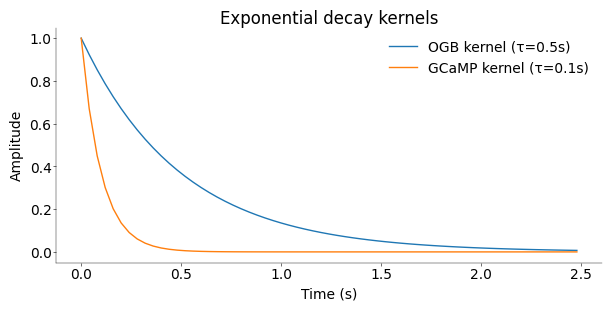

In [10]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

# Parameters
dt = 1 / 25.0  # sampling interval (s)
tau_ogb = 0.5
tau_gcamp = 0.1

# Compute kernels
t_max = 5 * max(tau_ogb, tau_gcamp)
t = np.arange(0, t_max, dt)
h_ogb = np.exp(-t / tau_ogb)
h_gcamp = np.exp(-t / tau_gcamp)

# Plot kernels
plt.figure(figsize=(6, 3))
plt.plot(t, h_ogb, label=f"OGB kernel (τ={tau_ogb}s)")
plt.plot(t, h_gcamp, label=f"GCaMP kernel (τ={tau_gcamp}s)")
plt.title("Exponential decay kernels")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Questions (1 pt)
1) Explain how you constructed the kernels

We model each calcium indicator as a first‐order (AR(1)) system whose impulse response is exp(- t / tau), with tau being the constant determening the steepness decay which differs between OGB ( tau = 0.5) and GCamp (tau = 0.1). To descretize we sample t from 0 to 5 at an rate of 25 Hz (i.e. delta t = 1/25). 

2) How do the indicators / kernels compare?

depending on the time constant tau:
- OGB:    0.5 s   → slower decay
- GCaMP:  0.1 s   → faster decay

Temporal width:
- OGB kernel spans    ≈ 2.5 s (decays to ~1% by 5 τ)  → better smoothing, lower temporal precision
- GCaMP kernel spans  ≈ 0.5 s                         → sharper response, higher temporal precision

Implications for deconvolution:
- OGB:    broader kernel      → deconvolved spike train is smoother and integrates over longer periods; slow dynamics can blur close spikes
- GCaMP:  narrower kernel     → deconvolution yields sharper, more time‐locked spike estimates but this may also amplify noise


3) What are pros and cons of each indicator?

-- OGB
- Pros
- High signal‐to‐noise & smooth estimates: its slow decay integrates calcium over a longer period of time, so deconvolution yields a  smooth, low‐noise rate trace which might help detecting slow rate changes or tonic firing
- Robust against edge‐effects: the broad exponential kernel minimizes high‐frequency amplification and artifacts
- Strong fluorescence: as it´s a synthetic dye it typically gives bright signals per spike
- Cons
- Temporal precision: because each spike “echoes” for ~ 2.5 s (5 × τ) in the kernel, closely spaced spikes (<1 s apart) will blur together and cannot be resolved
- Invasive & non‐selective: labels all nearby cells indiscriminately, and is generally acute rather than chronic

-- GCamp
- Pros
- High temporal precision: the fast decay allows deconvolution to resolve spikes tens of milliseconds apart
- Cell‐type specificity & chronic imaging: genetic targeting makes it possible to record fro defined populations of cells over a long period of time
- Cons
- Lower SNR & noisier estimates: the narrow kernel gives less temporal averaging, so the deconvolved rate is more susceptible to high‐frequency noise
- Spike‐miss rate & non-linearity: misses ~10% of single spikes 
- Indicator saturation: for higher firing rates intracellular Ca doesn’t return to baseline between spikes. The sensor’s binding sites become progressively occupied, so each additional spike produces a smaller incremental ΔF/F—i.e. the fluorescence plateaus as we approach the sensor’s maximal dynamic range

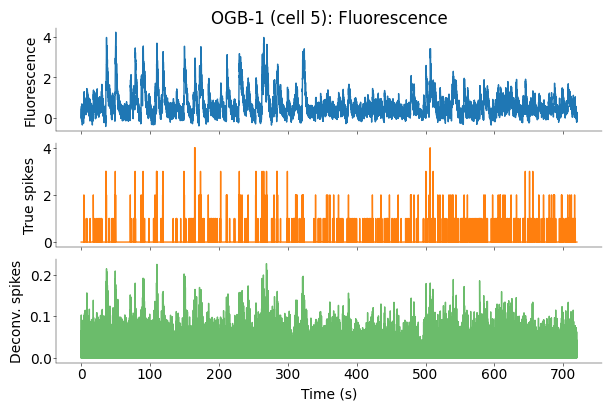

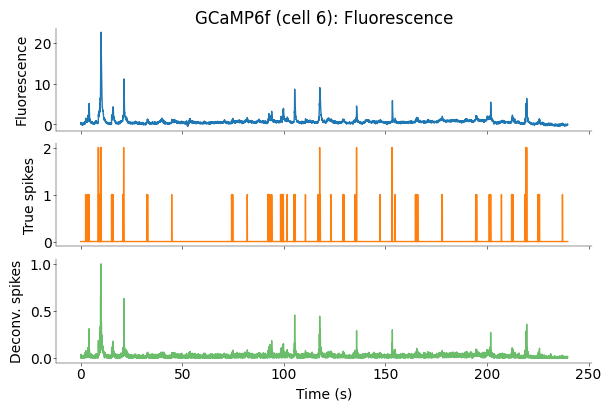

In [ ]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------
# Parameters
dt = 1 / 25.0  # sampling interval (s)
tau_ogb = 0.5
tau_gcamp = 0.1

# Compute kernels
t_max = 5 * max(tau_ogb, tau_gcamp)
t = np.arange(0, t_max, dt)
h_ogb = np.exp(-t / tau_ogb)
h_gcamp = np.exp(-t / tau_gcamp)

# Deconvolve example cells
sp_hat_ogb = deconv_ca(cell_ogb, tau_ogb, dt)
sp_hat_gcam = deconv_ca(cell_gcam, tau_gcamp, dt)

# Normalize both true and estimated to the same max = 1
scale_ogb = max(spk_ogb.max(), sp_hat_ogb.max(), 1e-12)
scale_gcam = max(spk_gcam.max(), sp_hat_gcam.max(), 1e-12)

sp_hat_ogb_norm = sp_hat_ogb / scale_ogb
sp_hat_gcam_norm = sp_hat_gcam / scale_gcam

# Time axes
t_ogb = np.arange(len(cell_ogb)) / 25.0
t_gcamp = np.arange(len(cell_gcam)) / 25.0

# Zoom window: 10–30 s
i0, i1 = np.searchsorted(t_ogb, [10, 30])
j0, j1 = np.searchsorted(t_gcamp, [10, 30])
fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

# Row 1: raw Ca trace
axs[0].plot(t_ogb, cell_ogb, color="tab:blue")
axs[0].set_ylabel("Fluorescence")
axs[0].set_title("OGB-1 (cell 5): Fluorescence")
axs[0].label_outer()  # hide x-ticklabels here

# Row 2: true spikes
axs[1].plot(t_ogb[:-1], spk_ogb, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: deconvolved spikes
axs[2].plot(t_ogb, sp_hat_ogb_norm, color="tab:green", alpha=0.7)
axs[2].set_ylabel("Deconv. spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell

# Row 1: raw Ca trace
axs[0].plot(t_gcamp, cell_gcam, color="tab:blue")
axs[0].set_ylabel("Fluorescence")
axs[0].set_title("GCaMP6f (cell 6): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_gcamp[:-1], spk_gcam, color="tab:orange", label="True spikes")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: deconvolved spikes
axs[2].plot(t_gcamp, sp_hat_gcam_norm, color="tab:green", alpha=0.7)
axs[2].set_ylabel("Deconv. spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

-- OGB-1 (τ = 0.5 s)
- The deconvolved trace is smooth, with broader, low-amplitude bumps rather than sharp peaks.
- Closely spaced true spikes merge into a single, prolonged event in the estimate.
--> the AR(1) inversion effectively averages over the time window — which is good for denoising but blurs events that happen within a couple seconds of each other

-- GCaMP6f (τ = 0.1 s)
- The deconvolved trace shows sharper, high-amplitude peaks closely aligned to individual true spikes
- However, the baseline is noisier and you occasionally see small spurious blips between real spikes
--> we seem to miss to detect spikes especially if there are only small flouresence peaks. Single spikes seem to not yield a strong enough floursence response

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [12]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
#!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [13]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

# Run fast-oopsi
dt = 1 / 25.0  # seconds per frame at 25 Hz
# returns inferred spike train `n_*` and reconstructed Ca trace `C_*`
n_ogb, C_ogb = oopsi.fast(cell_ogb, dt, iter_max=6, update=True)
n_gcamp, C_gcamp = oopsi.fast(cell_gcam, dt, iter_max=6, update=True)


# Time axes & zoom window
t_ogb = np.arange(len(cell_ogb)) / 25.0
t_gcamp = np.arange(len(cell_gcam)) / 25.0
i0, i1 = np.searchsorted(t_ogb, [10, 30])
j0, j1 = np.searchsorted(t_gcamp, [10, 30])

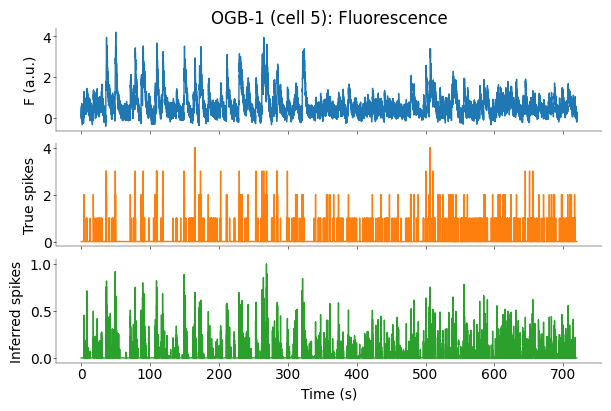

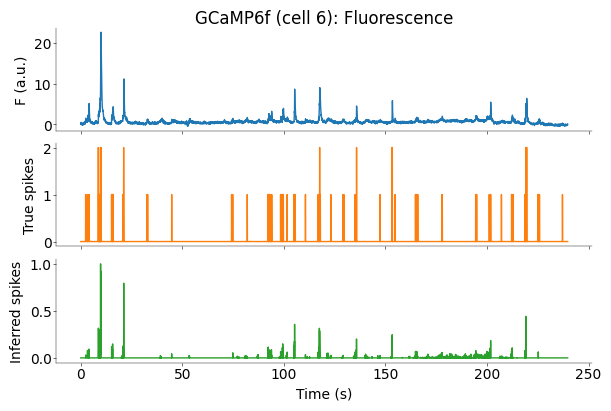

In [14]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

# OGB Cell
fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), gridspec_kw={"height_ratios": [1, 1, 1], "hspace": 0}
)

# Row 1: raw Ca trace
axs[0].plot(t_ogb, cell_ogb, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("OGB-1 (cell 5): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_ogb[:-1], spk_ogb, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: inferred spikes
axs[2].plot(t_ogb, n_ogb, color="tab:green")
axs[2].set_ylabel("Inferred spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

# GCamP Cell
fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), gridspec_kw={"height_ratios": [1, 1, 1], "hspace": 0}
)

# Row 1: raw Ca trace
axs[0].plot(t_gcamp, cell_gcam, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("GCaMP6f (cell 6): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_gcamp[:-1], spk_gcam, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: inferred spikes
axs[2].plot(t_gcamp, n_gcamp, color="tab:green")
axs[2].set_ylabel("Inferred spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [15]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [16]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [17]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")